## Stats 131: Final Project
### Kaylin Dee

Basic Exploratory Analysis of League of Legends' Kaggle Data

###### Import Packages

In [1]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from ast import literal_eval
from pandas.core.reshape.reshape import unstack

###### League of Legends DataSets

In [2]:
#import first dataset
LoL = pd.read_csv('C:/Users/Kaylin/Documents/Data Sets/League of Legends/LeagueofLegends.csv')
#LoL.info() #7620 x 57

In [3]:
#second dataset on structures taken down
#structures = pd.read_csv(''C:/Users/Kaylin/Documents/Data Sets/League of Legends/structures.csv'')
#structures.info() #121386 x 5

In [4]:
#third dataset on kills 
#kills = pd.read_csv(''C:/Users/Kaylin/Documents/Data Sets/League of Legends/kills.csv'')
#kills.info()

###### Merging Data Sets

In [5]:
#league = LoL.merge(structures, left_on = "Address", right_on = "Address")
#league.info()

###### Changing some Columns

In [6]:
#league.rename(columns={'Type_x': 'GameType', 'Type_y': 'StructureType'}, inplace=True)
#league.info()

## Subsetting only 2017 Season Data

We chose to focus on 2017 because it is the most recent, complete year. We also only want to focus on Season rows.

In [7]:
y2017 = LoL.loc[LoL['Year'] == 2017,]
y2017 = y2017.loc[y2017['Type'] == 'Season']

## Exploring Game Length

In [8]:
y2017['gamelength'].describe()

count    2572.000000
mean       36.240669
std         7.799661
min        17.000000
25%        31.000000
50%        35.000000
75%        41.000000
max        78.000000
Name: gamelength, dtype: float64

In [9]:
y2017_2 = y2017[y2017.gamelength > 65]
y2017_2.shape 

(10, 57)

There are only 10 games over 65 minutes out of the 2572. This is about 3 standard deviations above the 75% quartile.

We'll just clean it up a bit and take these out

In [10]:
y2017 = y2017[y2017.gamelength <= 65]
y2017['gamelength'].describe()

count    2562.000000
mean       36.112412
std         7.535977
min        17.000000
25%        30.000000
50%        35.000000
75%        41.000000
max        65.000000
Name: gamelength, dtype: float64

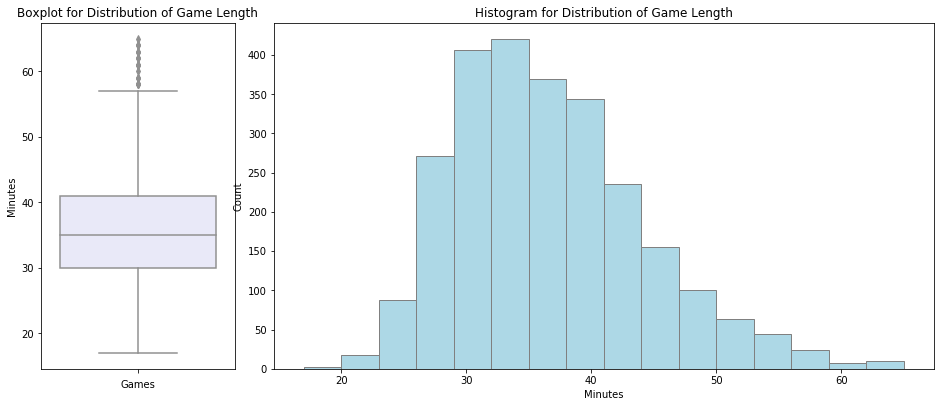

In [11]:
fig, ax = plt.subplots(0,2, figsize=(16,14))

p1 = plt.subplot2grid((2,4), (0,0), colspan = 1)
sns.boxplot(y = y2017['gamelength'], color = 'lavender')
plt.title("Boxplot for Distribution of Game Length")
plt.xlabel("Games") 
plt.ylabel("Minutes")

p2 = plt.subplot2grid((2,4), (0,1), colspan = 3)
plt.hist(x= 'gamelength', bins = 16, data = y2017, color = 'lightblue', edgecolor = 'grey')
plt.title("Histogram for Distribution of Game Length")
plt.xlabel("Minutes")
plt.ylabel("Count")

plt.show()

## Looking at Gold over Time

## Looking at Most Banned Champions in 2017

In [12]:
blueBans2017 = y2017['blueBans'].apply(literal_eval)
redBans2017 = y2017['redBans'].apply(literal_eval)

bans = blueBans2017.append(redBans2017) #combine the red and blue bans for a total bans data frame

In [13]:
#dfBlueBans = pd.DataFrame(blueBans2017)
#dfRedBans = pd.DataFrame(redBans2017)

dfBans = pd.DataFrame(bans) #create the data frame
dfBans.columns = ["bans"] #rename the column 

In [14]:
#dfBlueBans.info()

In [15]:
#dfRedBans.info()

In [16]:
dfBans.shape #to check if both columns were combined correctly, the shape needs 6622 rows because the original set had 3311 obs
dfBans.head()

,bans
609,"[Rengar, Olaf, Janna, Nautilus, Poppy]"
610,"[Zyra, Maokai, Ryze, Fiora, Jayce]"
611,"[Zyra, Syndra, Ryze, Orianna, Karma]"
612,"[Ryze, Kennen, Malzahar, Zyra, Rumble]"
613,"[Kalista, Olaf, Zyra, MissFortune, Ekko]"


In [17]:
lst_col = 'bans'

#get the names out of the 'pseudo'-list
b = pd.DataFrame({
    col:np.repeat(dfBans[col].values, dfBans[lst_col].str.len())
    for col in dfBans.columns.drop(lst_col)}).assign(**{lst_col:np.concatenate(dfBans[lst_col].values)})[dfBans.columns]

b.shape #32694 total bans in 2017 for competitive matches

(25437, 1)

In [18]:
#get the total each champion in 2017 was banned in competitive matches
mostcommon1 = b.groupby('bans')['bans'].count()

#sort from largest to smallest; observe the top 20
mostcommon1sort =mostcommon1.sort_values(ascending = False)[0:10]

In [19]:
#turn into a dataframe
mostcommon1df= pd.DataFrame(mostcommon1sort)
mostcommon1df = mostcommon1df.reindex(mostcommon1df.index.rename('Champion'))
mostcommon1df.reset_index(level=0, inplace=True)

In [24]:

#table = plt.table(cellText=mostcommon1df.values, 
 #                 colWidths = [0.25]*len(mostcommon1df.columns),
  #                bbox = [0, 1, 0.5, 1],
   #               loc = 'left')
print(mostcommon1df)

  Champion  bans
0  Leblanc  1516
1  Camille  1159
2   Syndra  1082
3      Zac  1078
4    Elise   995
5  Caitlyn   840
6    Jayce   836
7   Rengar   788
8     Shen   785
9   Thresh   683


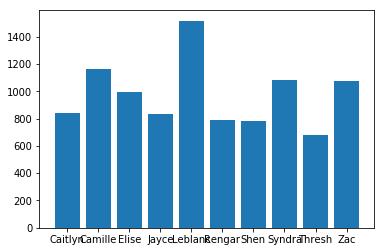

In [21]:
barchart = plt.bar(mostcommon1df['Champion'], mostcommon1df['bans'])

From this table and barplot, we can see that the most common champion banned during the 2017 Season was LeBlanc.

## Does the time of taking down the first objective increase a team's chance of winning?

Does taking down the first tower/objective earlier increase your chances of winning/give you a head start? 